In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
df = pd.read_csv("fina_Stage_unaugmented.csv")
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

C:\Users\pc\AppData\Local\Temp\ipykernel_8576\650628951.py:4: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("fina_Stage_unaugmented.csv")


In [26]:
print(df.head(3))

        Stage                       Samples  oct_embedded preservation_method  \
0  Stage IIIC  TCGA-A2-A25D-01A-12R-A16F-07          True                 OCT   
2    Stage IA  TCGA-BH-A201-01A-11R-A14M-07          True                 OCT   
4   Stage IIB  TCGA-AC-A23C-01A-12R-A169-07         False             Unknown   

   days_to_collection  initial_weight                 pathology_report_uuid  \
0               224.0           430.0  BE63B06A-E3E0-4E00-9B9F-5E7DE8852E07   
2                86.0           120.0  6AE92F6F-E29D-43B6-AF1E-F15720C1AAE8   
4               198.0           100.0  926E93B6-EF7C-4F13-824D-13D08B7F7938   

  synchronous_malignancy laterality  \
0                     No      Right   
2                     No       Left   
4                     No       Left   

                                          treatments  ...       TUBA1B  \
0  c(0, 0, NA, NA, 0), c("mg", NA, "mg/day", NA, ...  ...   888.126605   
2  c("Adjuvant", NA, "First-Line Therapy"), c("20... 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import joblib

df = pd.read_csv('fina_Stage_unaugmented.csv', low_memory=False)
df = df.drop_duplicates(subset='Samples')
df = df.dropna(subset=['Stage'])

y = df['Stage']

drop_cols = [
    'Samples', 'Stage', 'vital_status', 'submitter_id', 'barcode',
    'sample_id', 'sample', 'sample_submitter_id', 'patient', 'paper_patient',
    'diagnosis_id', 'bcr_patient_barcode',  
    'paper_age_at_initial_pathologic_diagnosis', 'paper_days_to_birth',
    'paper_pathologic_stage', 'ajcc_pathologic_n', 'ajcc_pathologic_t',
    'ajcc_pathologic_m', 'year_of_diagnosis', 'treatments', 'Unnamed: 0',
    'paper_days_to_last_followup', 'days_to_collection', 'demographic_id',
    'initial_weight', 'days_to_birth', 'pathology_report_uuid',
    'age_at_diagnosis', 'age_at_index', 'method_of_diagnosis',
    'sites_of_involvement', 'primary_diagnosis', 'morphology',
    'paper_PARADIGM.Clusters', 'paper_Mutation.Clusters', 'paper_CNV.Clusters',
    'paper_BRCA_Subtype_PAM50', 'paper_miRNA.Clusters', 'paper_DNA.Methylation.Clusters',
    'paper_Included_in_previous_marker_papers', 'paper_mRNA.Clusters',
    'ethnicity', 'preservation_method', 'race', 'laterality',
    'paper_vital_status', 'oct_embedded', 'prior_malignancy',
    'synchronous_malignancy', 'age_is_obfuscated', 'prior_treatment',
    'tissue_or_organ_of_origin', 'icd_10_code'
]
X = df.drop(columns=[col for col in drop_cols if col in df.columns])
X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y.loc[X.index]


# Label Encoding Standardize + PCA
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "label_encoder.save")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler.save")

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
joblib.dump(pca, "pca.save")


smote = SMOTE(random_state=42,  k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_pca, y_encoded)

num_classes = len(np.unique(y_resampled))
y_onehot = tf.keras.utils.to_categorical(y_resampled, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_onehot, test_size=0.2, random_state=42
)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
present_labels = np.unique(y_true_classes)
present_class_names = label_encoder.classes_[present_labels].astype(str)

print(classification_report(
    y_true_classes, y_pred_classes,
    labels=present_labels,
    target_names=present_class_names
))

model.save("brca_NN_vanila_another.keras")



Epoch 1/30
82/82 [==============================] - 0s 2ms/step - loss: 1.8766 - accuracy: 0.4450 - val_loss: 0.9346 - val_accuracy: 0.7282
Epoch 2/30
82/82 [==============================] - 0s 1ms/step - loss: 0.9138 - accuracy: 0.7166 - val_loss: 0.6662 - val_accuracy: 0.7802
Epoch 3/30
82/82 [==============================] - 0s 1ms/step - loss: 0.6067 - accuracy: 0.8102 - val_loss: 0.5250 - val_accuracy: 0.8412
Epoch 4/30
82/82 [==============================] - 0s 1ms/step - loss: 0.4436 - accuracy: 0.8587 - val_loss: 0.4627 - val_accuracy: 0.8580
Epoch 5/30
82/82 [==============================] - 0s 1ms/step - loss: 0.2969 - accuracy: 0.9079 - val_loss: 0.4416 - val_accuracy: 0.8626
Epoch 6/30
82/82 [==============================] - 0s 1ms/step - loss: 0.2468 - accuracy: 0.9202 - val_loss: 0.4184 - val_accuracy: 0.8656
Epoch 7/30
82/82 [==============================] - 0s 1ms/step - loss: 0.1859 - accuracy: 0.9389 - val_loss: 0.4006 - val_accuracy: 0.8763
Epoch 8/30
82/82 [==

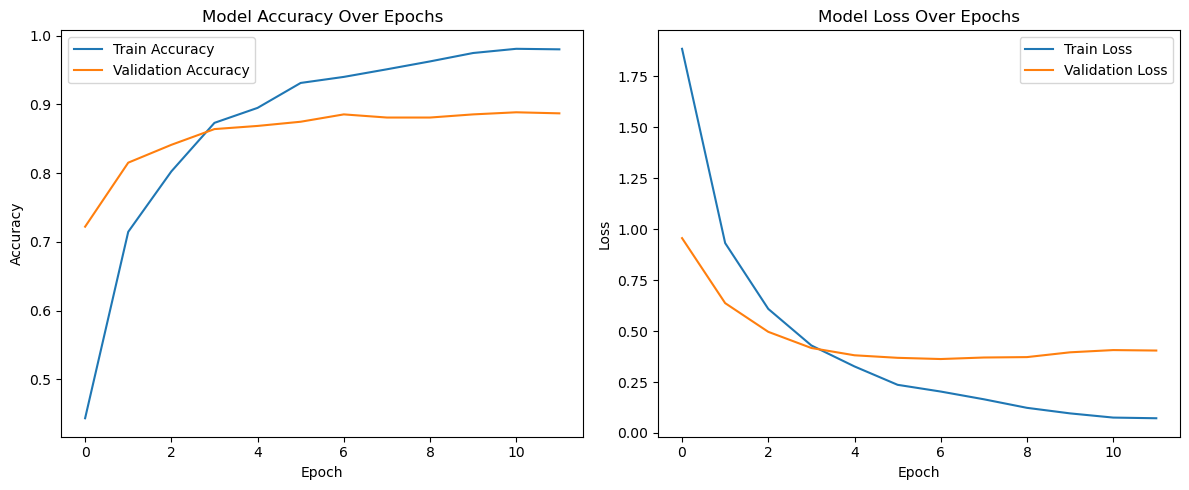

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


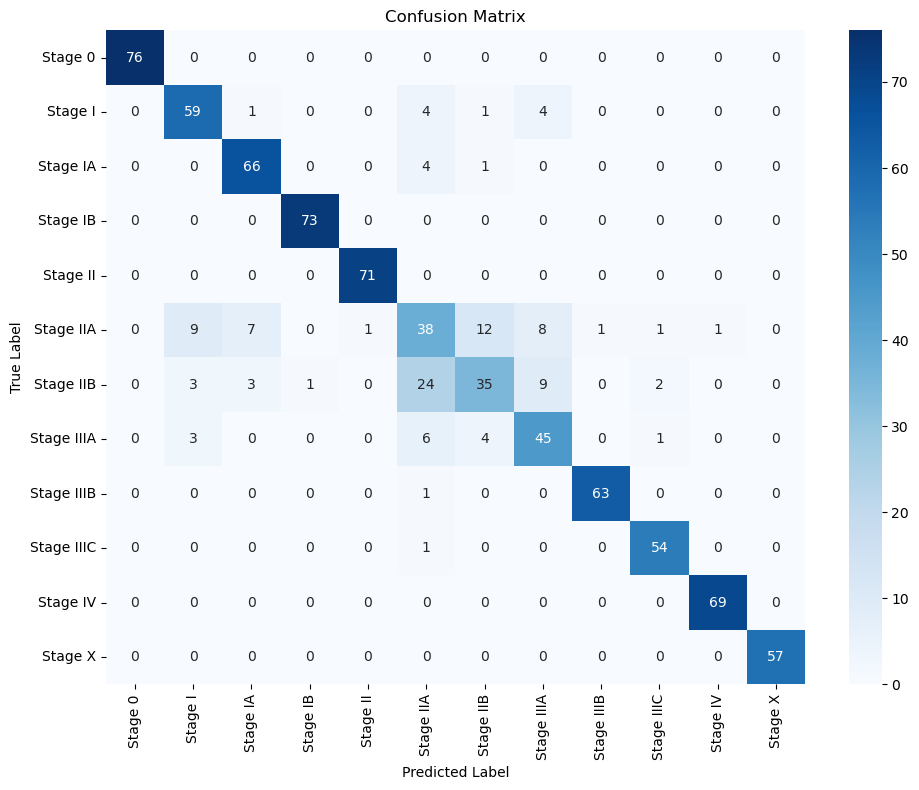

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=present_class_names,
            yticklabels=present_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


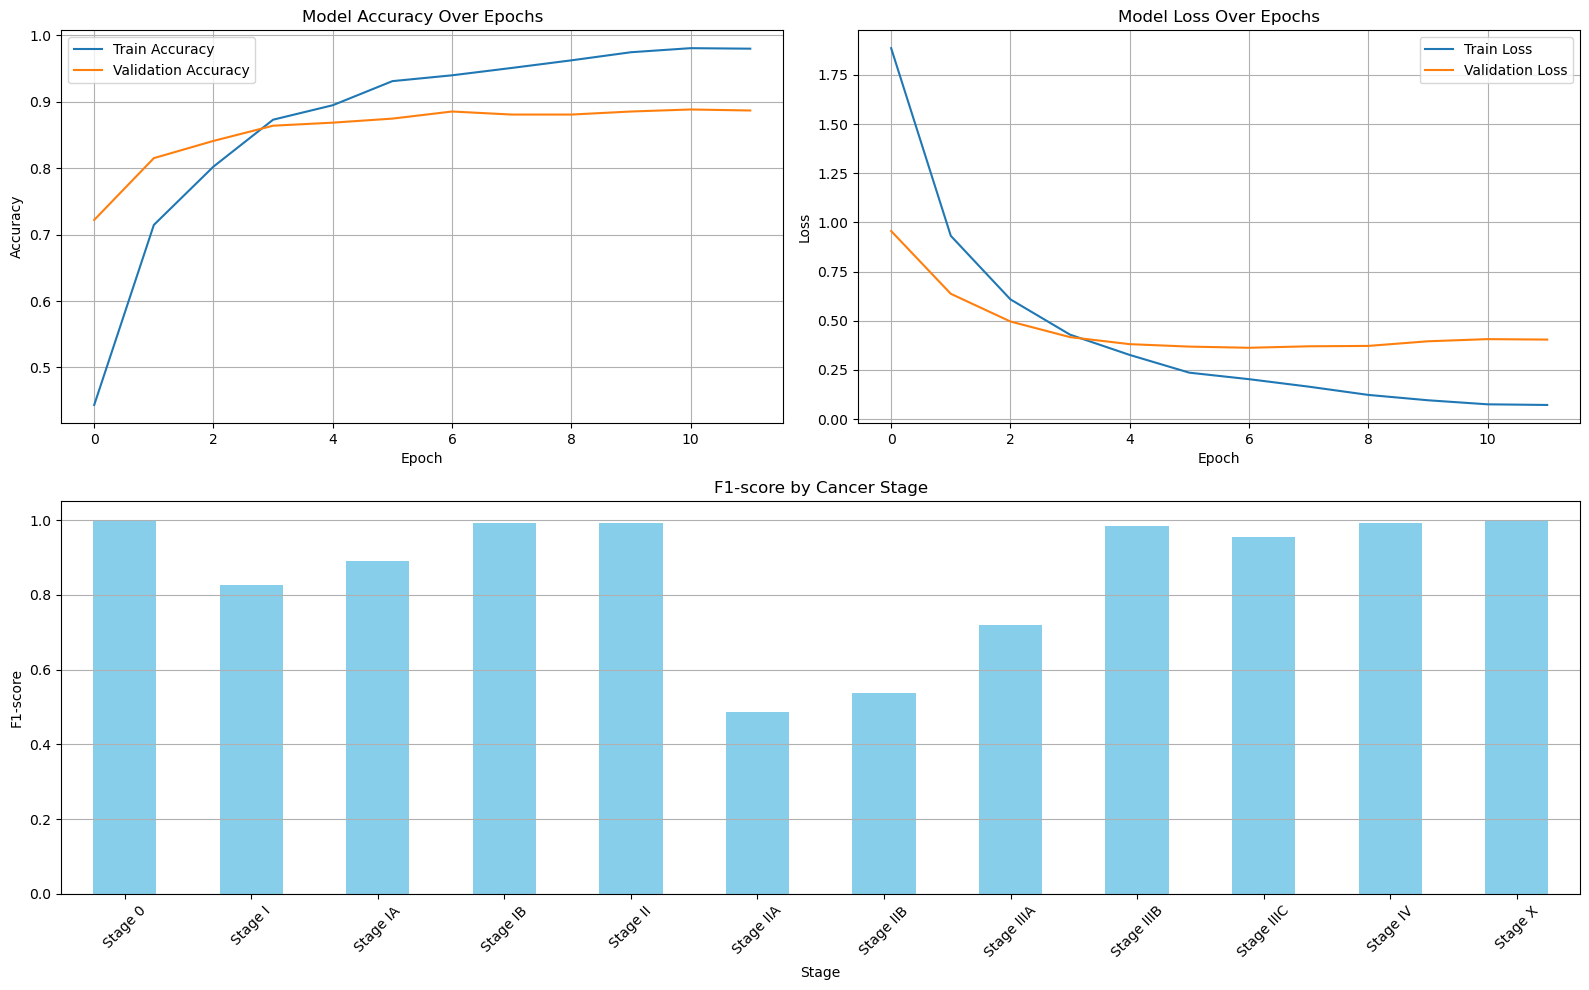

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Build classification report DataFrame
report = classification_report(
    y_true_classes, y_pred_classes,
    labels=present_labels,
    target_names=present_class_names,
    output_dict=True
)
df_report = pd.DataFrame(report).transpose()

# Create the full figure with 2 rows: top with 2 side-by-side, bottom full-width
fig = plt.figure(figsize=(16, 10))

# Top left: Accuracy
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Top right: Loss
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss Over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Bottom full row: F1-score
ax3 = fig.add_subplot(2, 1, 2)  # spans both columns
df_report.iloc[:-3]['f1-score'].plot(kind='bar', color='skyblue', ax=ax3)
ax3.set_title('F1-score by Cancer Stage')
ax3.set_ylabel('F1-score')
ax3.set_xlabel('Stage')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y')

plt.tight_layout()
plt.show()


Now, we examine a combined visualization that illustrates the learning dynamics and classification strength of our vanilla neural network. This figure is organized into two main sections: the top row captures the model’s training history (accuracy and loss), and the bottom row displays the F1-scores across each breast cancer stage class a crucial performance metric in this multi-class, imbalanced dataset. In the top-left subplot, the accuracy curves show how well the model fits the data over time. We observe that training accuracy improves steadily, rising from around 45% in the first epoch to over 98% by epoch 11. Meanwhile, validation accuracy increases more moderately, plateauing just below 90%. This trend indicates that the model is learning generalizable patterns in the data without immediately overfitting. However, the growing gap between training and validation accuracy after epoch 5 suggests that the model is starting to over-specialize on the training set — a known risk in deep learning, especially with high-capacity models trained on finite data.

The top-right plot shows a similar pattern in terms of loss. Both training and validation losses decrease sharply during the early epochs, reflecting rapid convergence. After this point, training loss continues to fall toward zero, but validation loss levels off and begins to slightly rise. This inflection point confirms the beginning of overfitting. Thankfully, regularization techniques like dropout, early stopping, and learning rate reduction were integrated into the model’s training loop to mitigate this and halt the training process before the model fully memorizes the training data. The F1-score bar chart in the second row presents a breakdown of classification performance across all 13 cancer stages. The F1-score combines precision and recall, making it ideal for evaluating model performance on imbalanced classes where accuracy alone can be misleading. In this plot, we see that the model performs exceptionally well on several stages, achieving F1-scores close to 1.0. However, performance varies across the board.

In [28]:
# Step 1: Load the full dataset
df = pd.read_csv("fina_Stage_unaugmented.csv", low_memory=False)
df = df.drop_duplicates(subset='Samples')
df = df.dropna(subset=['Stage'])

drop_cols = [
    'Samples', 'Stage', 'vital_status', 'submitter_id', 'barcode',
    'sample_id', 'sample', 'sample_submitter_id', 'patient', 'paper_patient',
    'diagnosis_id', 'bcr_patient_barcode',  
    'paper_age_at_initial_pathologic_diagnosis', 'paper_days_to_birth',
    'paper_pathologic_stage', 'ajcc_pathologic_n', 'ajcc_pathologic_t',
    'ajcc_pathologic_m', 'year_of_diagnosis', 'treatments', 'Unnamed: 0',
    'paper_days_to_last_followup', 'days_to_collection', 'demographic_id',
    'initial_weight', 'days_to_birth', 'pathology_report_uuid',
    'age_at_diagnosis', 'age_at_index', 'method_of_diagnosis',
    'sites_of_involvement', 'primary_diagnosis', 'morphology',
    'paper_PARADIGM.Clusters', 'paper_Mutation.Clusters', 'paper_CNV.Clusters',
    'paper_BRCA_Subtype_PAM50', 'paper_miRNA.Clusters', 'paper_DNA.Methylation.Clusters',
    'paper_Included_in_previous_marker_papers', 'paper_mRNA.Clusters',
    'ethnicity', 'preservation_method', 'race', 'laterality',
    'paper_vital_status', 'oct_embedded', 'prior_malignancy',
    'synchronous_malignancy', 'age_is_obfuscated', 'prior_treatment',
    'tissue_or_organ_of_origin', 'icd_10_code'
]

# Step 2: Drop columns and select numeric
X = df.drop(columns=[col for col in drop_cols if col in df.columns])
X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = df.loc[X.index, 'Stage']


random_idx = np.random.choice(X.index)
sample_df = X.loc[[random_idx]]
sample_df.to_csv("test_sample.csv", index=False)
true_label = y.loc[random_idx]
print(f"🎯 True Stage: {true_label}")
print("✅ Sample saved to test_sample.csv")

🎯 True Stage: Stage I
✅ Sample saved to test_sample.csv


In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# === Load and prepare training data to fit scaler and PCA ===
full_df = pd.read_csv("fina_Stage_unaugmented.csv", low_memory=False)
full_df = full_df.drop_duplicates(subset='Samples')
full_df = full_df.dropna(subset=['Stage'])

drop_cols = [
    'Samples', 'Stage', 'vital_status', 'submitter_id', 'barcode',
    'sample_id', 'sample', 'sample_submitter_id', 'patient', 'paper_patient',
    'diagnosis_id', 'bcr_patient_barcode',  
    'paper_age_at_initial_pathologic_diagnosis', 'paper_days_to_birth',
    'paper_pathologic_stage', 'ajcc_pathologic_n', 'ajcc_pathologic_t',
    'ajcc_pathologic_m', 'year_of_diagnosis', 'treatments', 'Unnamed: 0',
    'paper_days_to_last_followup', 'days_to_collection', 'demographic_id',
    'initial_weight', 'days_to_birth', 'pathology_report_uuid',
    'age_at_diagnosis', 'age_at_index', 'method_of_diagnosis',
    'sites_of_involvement', 'primary_diagnosis', 'morphology',
    'paper_PARADIGM.Clusters', 'paper_Mutation.Clusters', 'paper_CNV.Clusters',
    'paper_BRCA_Subtype_PAM50', 'paper_miRNA.Clusters', 'paper_DNA.Methylation.Clusters',
    'paper_Included_in_previous_marker_papers', 'paper_mRNA.Clusters',
    'ethnicity', 'preservation_method', 'race', 'laterality',
    'paper_vital_status', 'oct_embedded', 'prior_malignancy',
    'synchronous_malignancy', 'age_is_obfuscated', 'prior_treatment',
    'tissue_or_organ_of_origin', 'icd_10_code'
]

X_train_base = full_df.drop(columns=[col for col in drop_cols if col in full_df.columns])
X_train_base = X_train_base.select_dtypes(include=[np.number])
X_train_base.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_base.dropna(inplace=True)

y_train_base = full_df.loc[X_train_base.index, 'Stage']
label_encoder = LabelEncoder()
label_encoder.fit(y_train_base)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_base)

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# === Load user sample CSV ===
sample_df = pd.read_csv("test_sample.csv")  # <-- change this to your actual sample file

# Ensure same preprocessing
sample_df = sample_df.select_dtypes(include=[np.number])
sample_df = sample_df.dropna(axis=1)

# Apply scaler and PCA
sample_scaled = scaler.transform(sample_df)
sample_pca = pca.transform(sample_scaled)

# === Load model and predict ===
model = tf.keras.models.load_model("brca_NN_vanila_another.keras")
prediction = model.predict(sample_pca)

predicted_class = np.argmax(prediction, axis=1)[0]
predicted_stage = label_encoder.classes_[predicted_class]

print(f"🔍 Predicted Stage: {predicted_stage}")
print(f"📊 Raw Probabilities: {prediction}")

🔍 Predicted Stage: Stage I
📊 Raw Probabilities: [[1.0207633e-04 8.6207038e-01 1.3780936e-03 1.8083342e-06 1.4433876e-04
  5.6580141e-02 7.0868470e-02 2.4437218e-03 1.1818075e-05 5.6841406e-03
  7.4621406e-05 6.4034638e-04]]
